In [1]:
# IMPORTS FROM LABS #
import sys 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from skimage.color import rgb2hsv, rgb2gray
from skimage.morphology import erosion, closing, opening, disk, remove_small_holes, remove_small_objects, binary_dilation
from skimage.transform import rotate, resize, warp
from sklearn.metrics.pairwise import euclidean_distances
from skimage.measure import regionprops, find_contours
from sklearn.cluster import KMeans
import numpy as np
import cv2 
import platform
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from typing import Optional, Callable
from sklearn.metrics import accuracy_score, f1_score
from sklearn.covariance import LedoitWolf
import torch.optim as optim

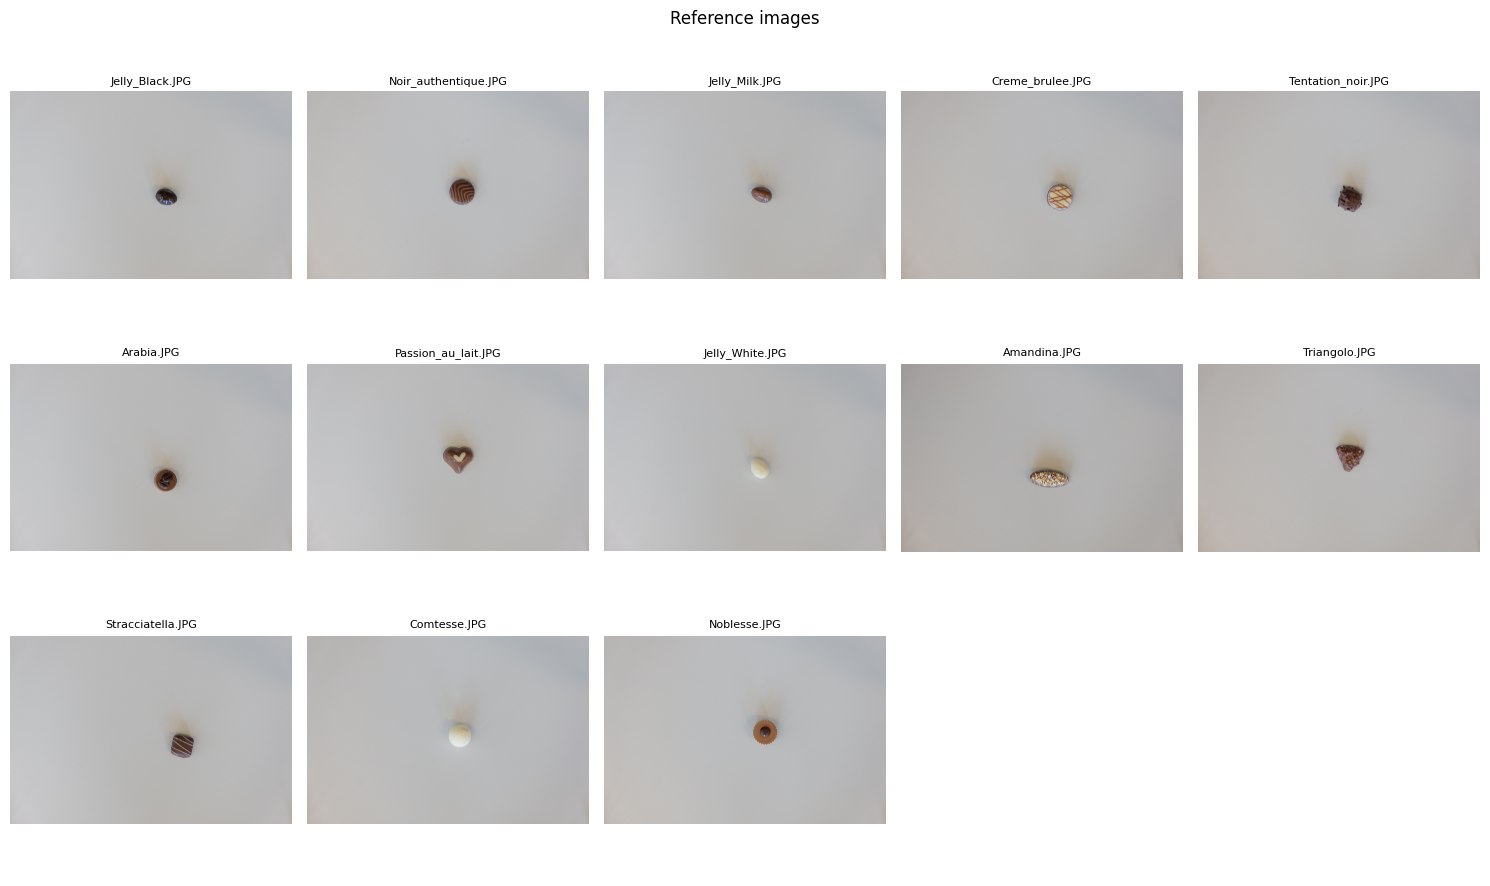

In [2]:
path_ref = '/Users/louiscuendet/Documents/EPFL NEURO-X /Image Analysis and Pattern Recognition/dataset_project_iapr2025/references'


jpg_files = [f for f in os.listdir(path_ref)]
n_images = len(jpg_files)

# Define grid size (square-ish)
cols = 5
rows = (n_images + cols - 1) // cols  # Round up division

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))

# Flatten axes array for easy iteration
axes = axes.flatten()

plt.suptitle('Reference images')
reference_images = []
for i, ax in enumerate(axes):
    if i < n_images:
        img_path = os.path.join(path_ref, jpg_files[i])
        img = mpimg.imread(img_path)
        reference_images.append(img)
        ax.imshow(img)
        ax.set_title(jpg_files[i], fontsize=8)
        ax.axis('off')
    else:
        ax.axis('off')  # Hide empty subplots

plt.tight_layout()
plt.show()

In [3]:
def segmentation(img):
    print('color variance of image',np.var(img))
    # --- 1. Load and Resize Image ---
    #img = cv2.imread('/Users/louiscuendet/Documents/EPFL NEURO-X /Image Analysis and Pattern Recognition/dataset_project_iapr2025/train/L1000756.JPG')
    img = cv2.resize(img, (512, 512))

    # --- 2. Convert to Grayscale ---
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # --- 3. Blur to Reduce Noise ---
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # --- 4. Canny Edge Detection ---
    edges = cv2.Canny(blurred, threshold1=10, threshold2=80)

    # --- 5. Dilate to Connect Broken Edges ---
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    dilated = cv2.dilate(edges, kernel, iterations=1)

    # --- 6. Morphological Closing to Fill Gaps ---
    closed = cv2.morphologyEx(dilated, cv2.MORPH_CLOSE, kernel, iterations=2)

    # --- 7. Remove Small Objects by Area Filtering ---
    # Find all contours
    contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # --- 7. Replace small contour filtering with ellipse fitting ---
    mask = np.zeros_like(closed)

    for cnt in contours:
        area = cv2.contourArea(cnt)
        # Skip tiny noise
        if area < 0:
            if len(cnt) >= 5:
                ellipse = cv2.fitEllipse(cnt)
                (x, y), (MA, ma), angle = ellipse
                if MA > 5 and ma > 5:
                    cv2.ellipse(mask, ellipse, 255, -1)
        else:
            # If not enough points, fall back to filled contour
            cv2.drawContours(mask, [cnt], -1, 255, thickness=cv2.FILLED)

    # --- 8. Apply Mask to Original Image ---
    segmented_objects = cv2.bitwise_and(img, img, mask=mask)
    
    extracted_chocolates = []

    for i, cnt in enumerate(contours):
        x, y, w, h = cv2.boundingRect(cnt)

        # Crop each object from the original image
        chocolate_crop = img[y:y+h, x:x+w]
        extracted_chocolates.append(chocolate_crop)

        # Optional: Display each one
        plt.figure()
        plt.imshow(cv2.cvtColor(chocolate_crop, cv2.COLOR_BGR2RGB))
        plt.title(f"Chocolate #{i+1}")
        plt.axis('off')
        plt.show()

    # --- 9. Display Results ---
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 3, 1)
    plt.title("Final Mask")
    plt.imshow(mask, cmap='gray')

    plt.subplot(1, 3, 2)
    plt.title("Objects Extracted")
    plt.imshow(cv2.cvtColor(segmented_objects, cv2.COLOR_BGR2RGB))

    plt.subplot(1, 3, 3)
    plt.title("real img")
    plt.imshow(img, cmap='gray')

    plt.tight_layout()
    plt.show()

color variance of image 130.9742180279257


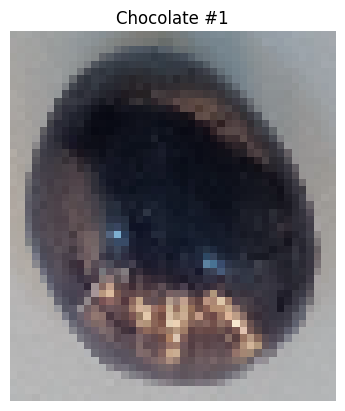

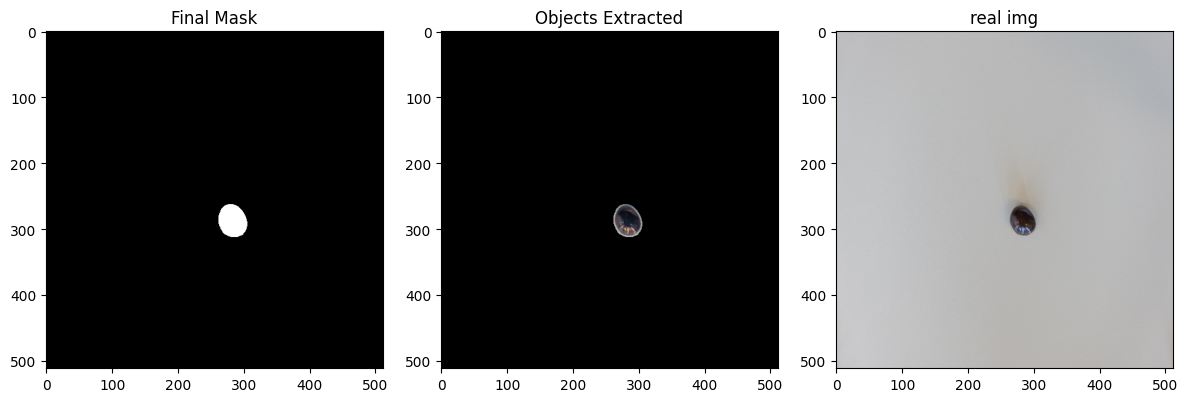

color variance of image 153.1966404995692


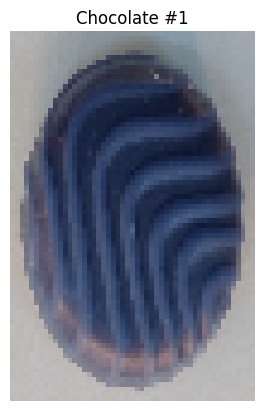

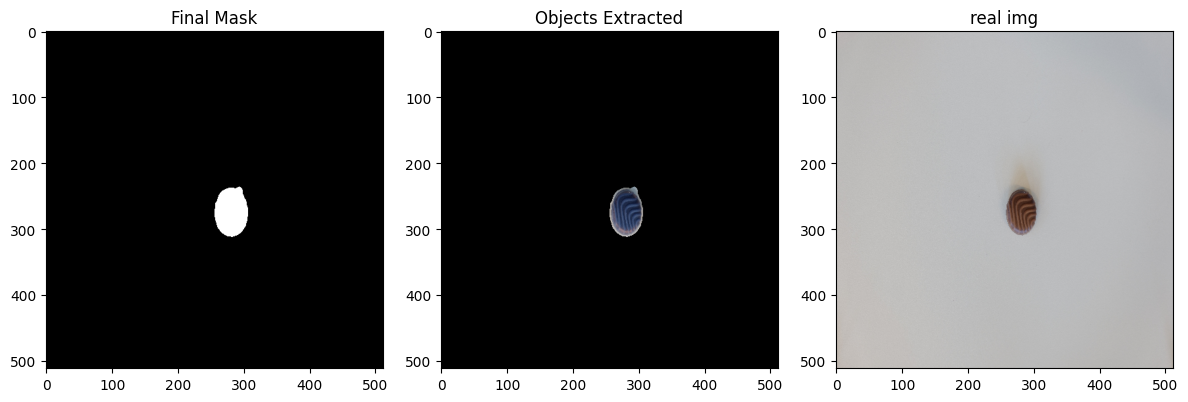

color variance of image 95.8596412727833


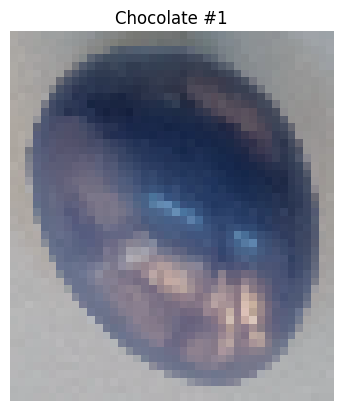

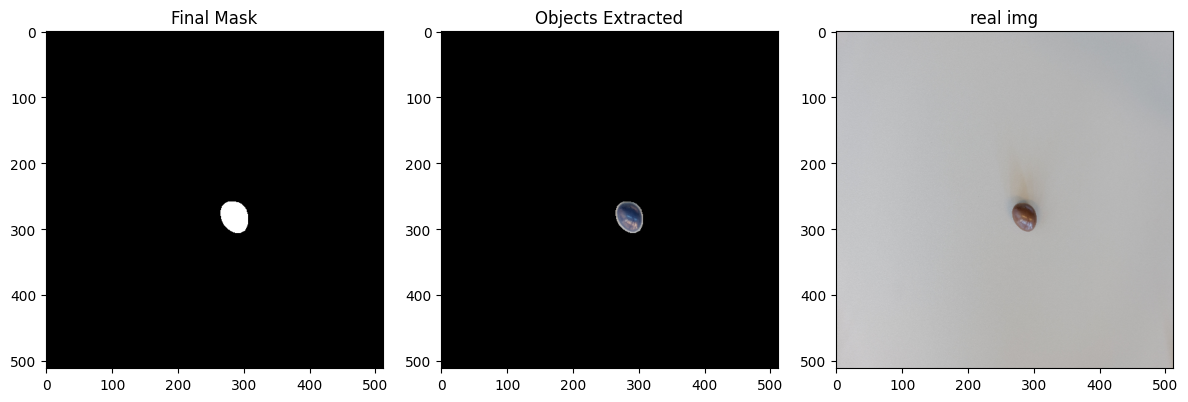

color variance of image 58.197045738382286


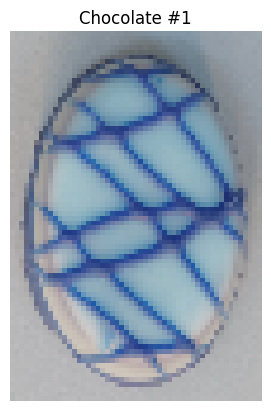

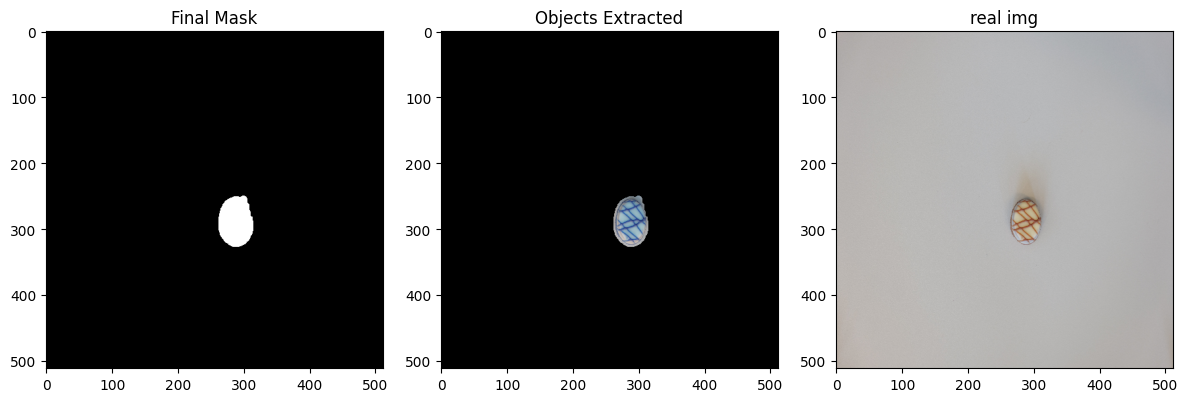

color variance of image 147.00294014149125


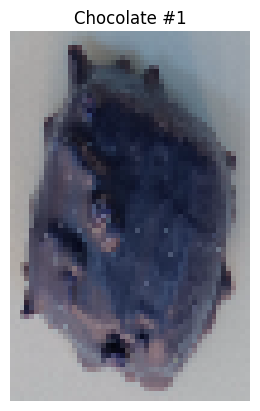

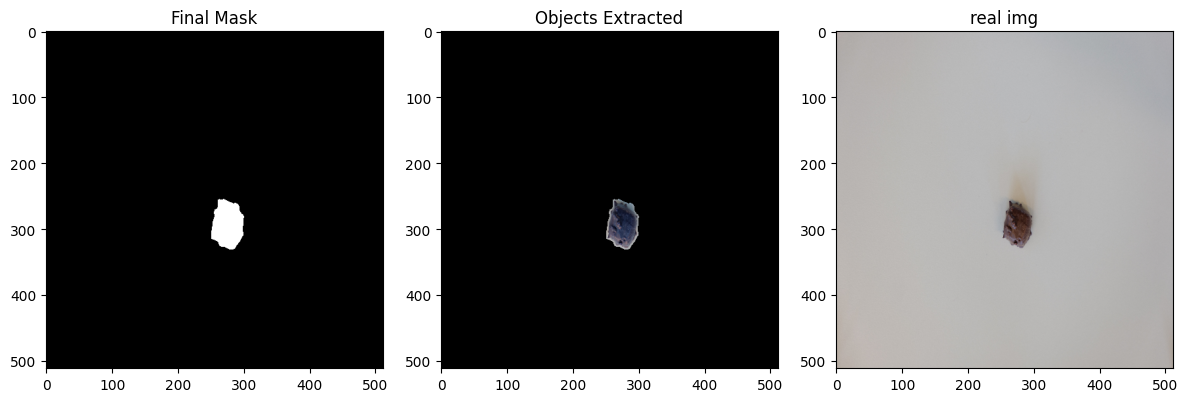

color variance of image 163.168883032548


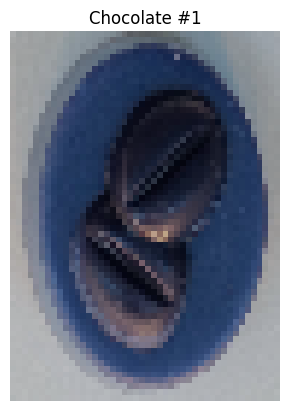

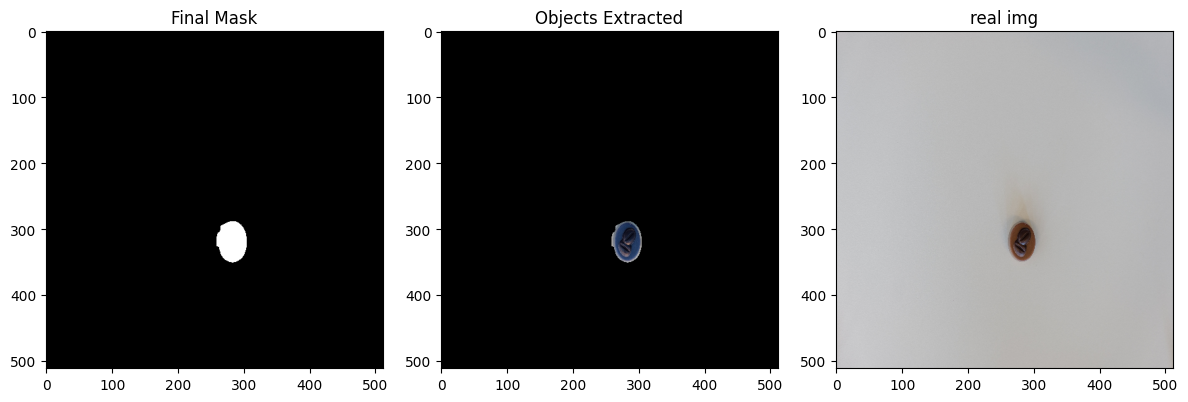

color variance of image 139.47275009513015


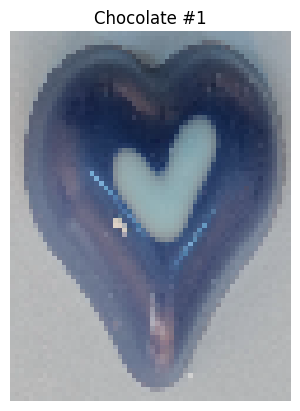

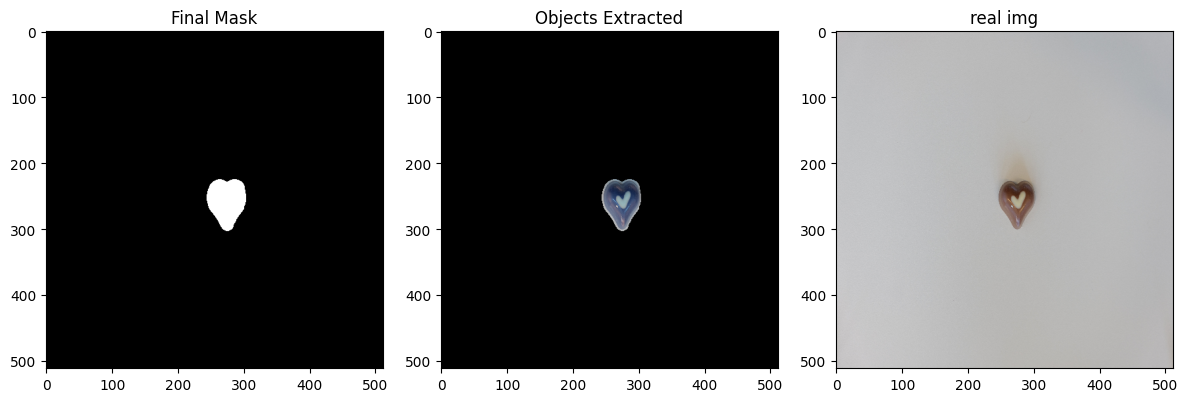

color variance of image 47.12830699791209


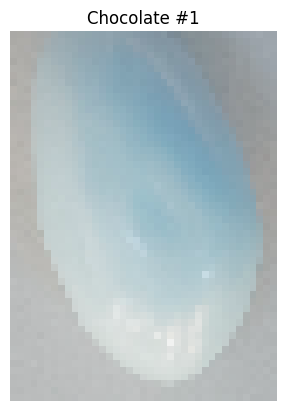

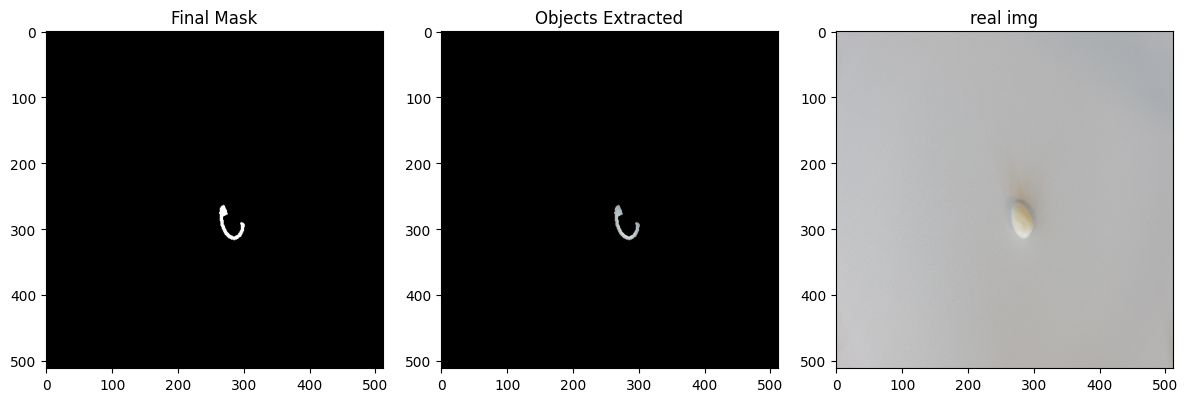

color variance of image 76.5672123513598


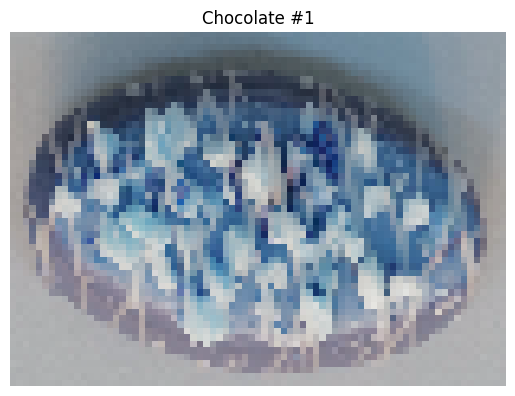

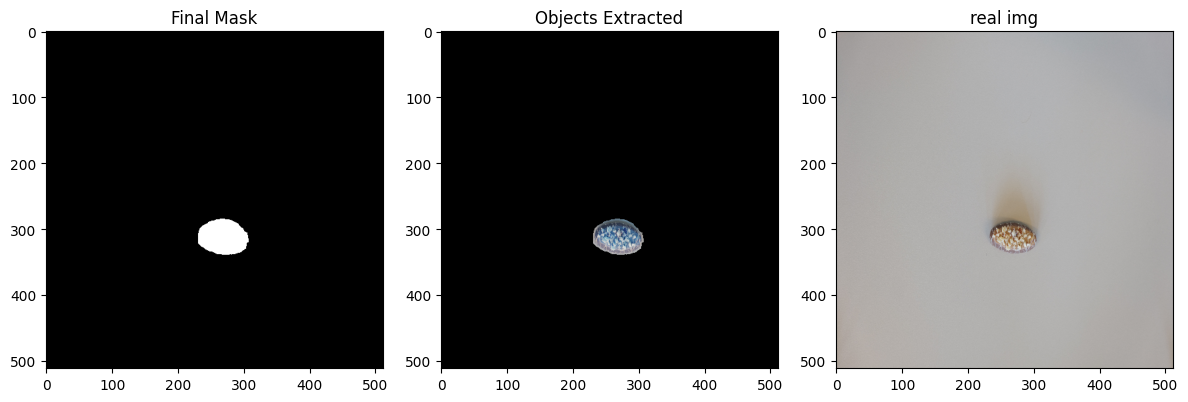

color variance of image 121.75129202060559


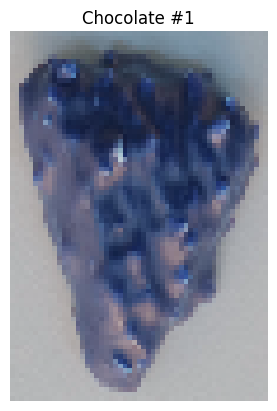

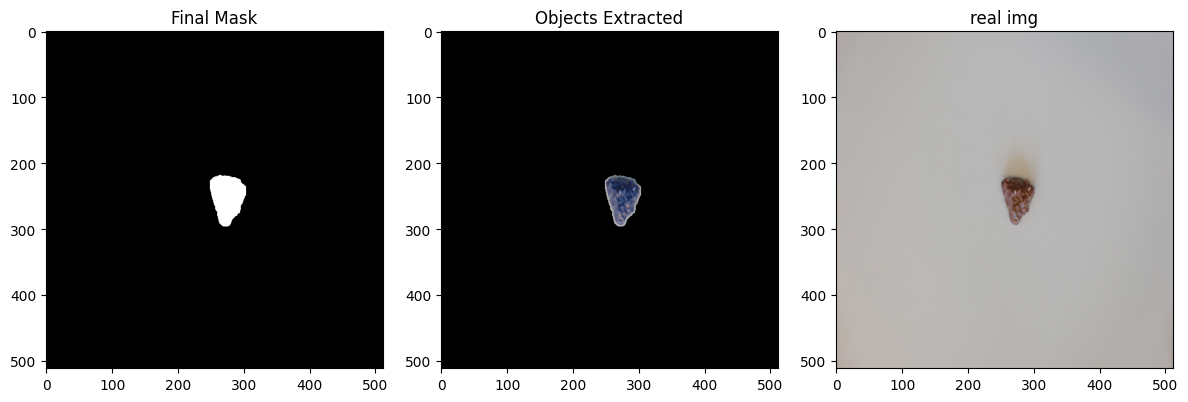

color variance of image 142.59644018148532


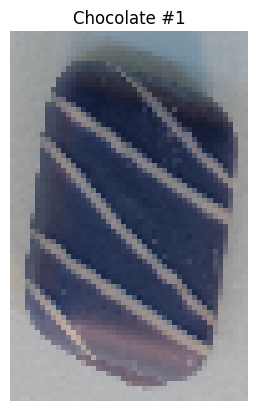

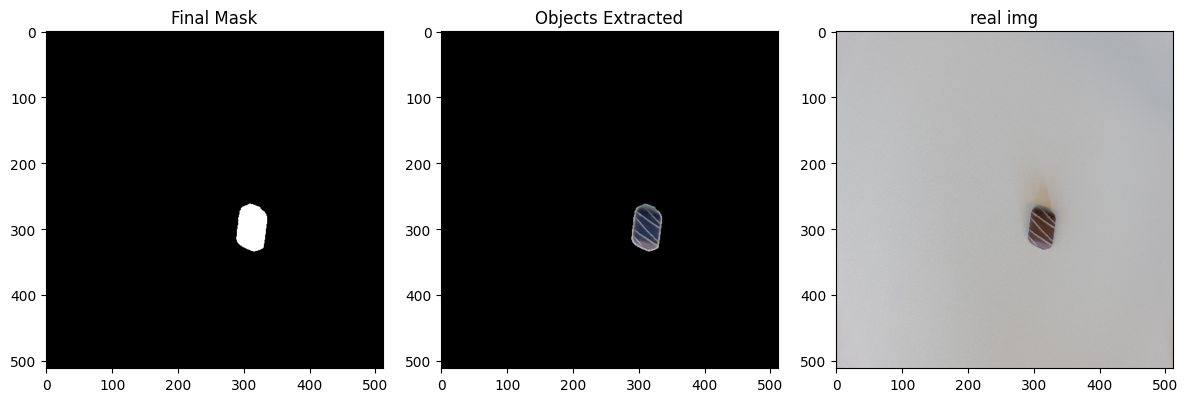

color variance of image 24.784770894661428


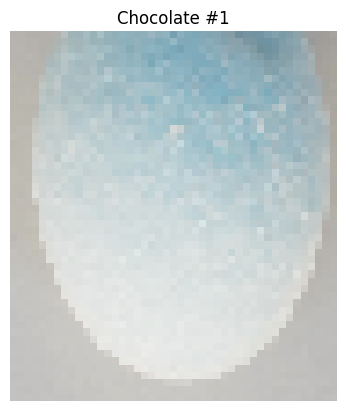

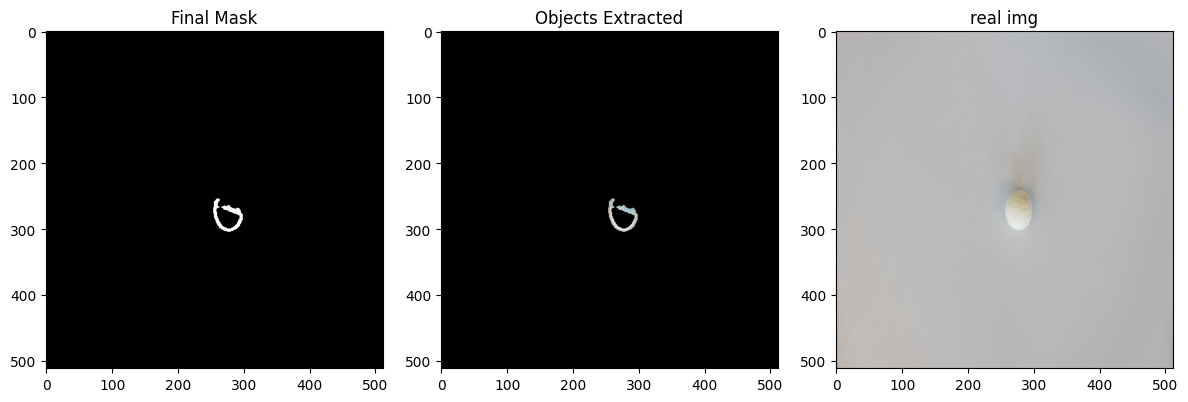

color variance of image 108.27469505986383


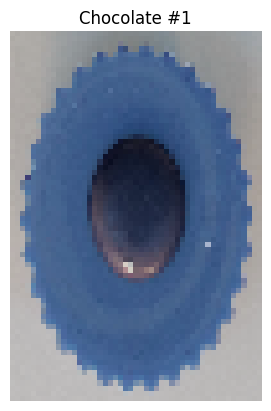

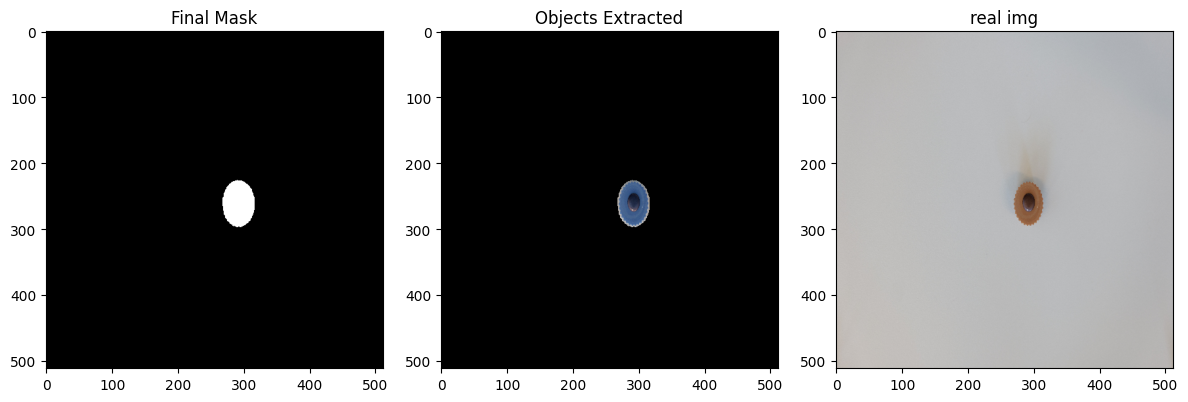

In [4]:
for img in reference_images:
    segmentation(img)